<a href="https://colab.research.google.com/github/4may/SuperResolutionSurvey/blob/master/SRCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Super-Resolution Convolutional Neural Network(SRCNN)

* 元祖、超解像度ネットワーク。

* [mediumに良さそうな記事](https://medium.com/datadriveninvestor/using-the-super-resolution-convolutional-neural-network-for-image-restoration-ff1e8420d846)があったので、試す。

* オリジナルの論文は[こちら](https://arxiv.org/abs/1501.00092)

## はじめに

* SRCNNはNNベースの超解像度手法
* 古来の超解像技術であるsparse coding method4よりも優れている

## アーキテクチャ

SRCNNの学習手順は以下の通り。

1. Preprocessing : 入力のLR画像を所望のHRサイズにupsamplingする. あくまでサイズを大きくしただけで、現時点ではHR画像になっていないことに注意(ぼやぼやーとした画像になっている)
2. Feature Extraction : upsamplingした画像からfeature mapを生成する
3. Non-linear mapping : feature mapから複数のパッチを作る。※パッチ：画像の一部部分を切り出したもの
4. Reconstruction : 3で作った複数のパッチを組み合わせてHR画像を生成する

以下に図で示す。

In [0]:
import matplotlib.pyplot as plt
import cv2

In [0]:
def show_image(filepath):
  plt.figure(figsize=(15, 15))
  img = cv2.imread(filepath)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

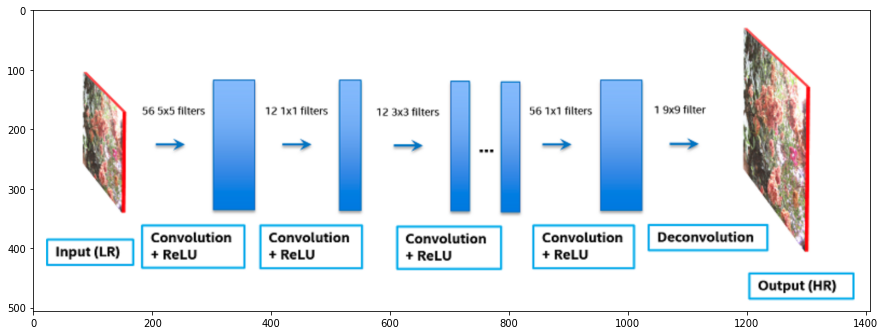

In [5]:
show_image("srcnn.png")

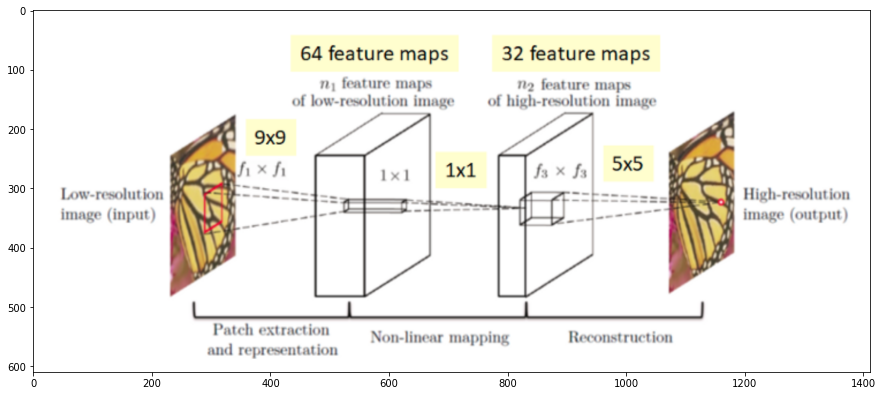

In [6]:
show_image("srcnn2.png")

### その他、実装に関する補足

* 以下の性能指標を使用する
  * PSNR
  * MSE
  * SSIM(Structual Similarity Index)
* データの前処理と後処理にOpenCVを使う
  * SRCNNは、RGBではなくYCrCb空間の画像データを扱う

## 実装

以下の手順で行う。

1. パッケージのインポート
2. 評価指標の定義
3. データの前処理
4. 評価指標の動作確認
5. モデリング
6. 学習

**1.パッケージのインポート**

tensorflowのkerasではなく、単独のkerasの方を使う。あとで、v2のtensorflowに書き直したい。

In [0]:
import sys
import keras
import matplotlib

In [0]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.optimizers import Adam
from matplotlib import pyplot as plt
import numpy as np
import cv2
import math
import os
from skimage.measure import compare_ssim as ssim

**2.評価指標の定義**

* MSE(Mean Squared Error) : 自作
* PSNR(Peak Signal to Noise Ratio) :　自作
* SSIM(Structual Similarity Index) : skimageの関数

また、3つの指標をまとめて計算する関数を一つ作成する。

In [0]:
#PSNRを計算する関数
def psnr(y_true, y_pred):
  #RGB値の場合はinteger型であるため、float型にキャストする必要がある
  y_pred_data = y_pred.astype(float)
  y_true_data = y_true.astype(float)

  diff = y_true_data - y_pred_data
  #引数の'C'はオーダーを表す。デフォルトだと'C'で、行優先にflattenする。
  #なお、この'C'はC言語のC。他にも、'F'(列優先)や'A', 'K'などが指定可能
  diff = diff.flatten('C')

  rmse = math.sqrt(np.mean(diff ** 2.))

  #最大ピクセル値(8bitのRGB画像であれば、255)
  max_pixel = 255.

  psnr = 20 * math.log10(max_pixel / rmse) if rmse != 0 else 0

  return psnr

In [0]:
#MSEを計算する関数
def mse(y_true, y_pred):
  y_pred_data = y_pred.astype(float)
  y_true_data = y_true.astype(float)
  num_data = float(y_pred.shape[0] * y_true.shape[1])
  err = np.sum((y_true_data - y_pred_data) ** 2)
  err /= num_data

  return err

In [0]:
#３つの指標をまとめて計算する関数
def compare_images(y_true, y_pred):
  scores = []
  scores.append(psnr(y_true, y_pred))
  scores.append(mse(y_true, y_pred))
  scores.append(ssim(y_true, y_pred, multichannel=True))

  return scores

**3.データの前処理**

* 低解像度の画像を作りたい
  * 画像サイズを小さくした後、元のサイズに戻すことで「歪み」を作る
* 論文では、91-imageデータセットを使っている。91-imageデータセットのうち、Set5とSet14の計19種類の画像データを扱う
* 今回の調査でも、論文で使用しているデータと同じデータを使う。
* 画像データは同じフォルダに格納しておく

In [0]:
def resize_image(dirpath, outdir, file, factor):
  #画像ファイルの読み取り
  in_filepath = os.path.join(dirpath, file)
  img = cv2.imread(in_filepath)

  #元のサイズ
  h, w, _ = img.shape

  #元の画像よりもfactor倍小さいサイズ
  new_height = int(h / factor)
  new_width = int(w / factor)

  #画像のサイズを小さくする
  img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_LINEAR)

  #画像のサイズを元に戻す
  img = cv2.resize(img, (w, h), interpolation=cv2.INTER_LINEAR)

  #画像を保存する
  print('Saving {}'.format(file))
  out_filepath = os.path.join(outdir, file)
  cv2.imwrite(out_filepath, img) 

def prepare_images(dirpath, factor):
  #出力先の画像フォルダを作成する
  outdir = 'images'
  if os.path.isdir(outdir) == False:
    os.mkdir(outdir)

  for file in filter(lambda x: 'bmp' in x, os.listdir(dirpath)):
    resize_image(dirpath, outdir, file, factor)

In [21]:
!unzip 'source.zip'

Archive:  source.zip
   creating: source/
  inflating: source/foreman.bmp      
  inflating: source/woman_GT.bmp     
  inflating: source/man.bmp          
  inflating: source/.DS_Store        
  inflating: source/pepper.bmp       
  inflating: source/comic.bmp        
  inflating: source/coastguard.bmp   
  inflating: source/butterfly_GT.bmp  
  inflating: source/baboon.bmp       
  inflating: source/bird_GT.bmp      
  inflating: source/monarch.bmp      
  inflating: source/flowers.bmp      
  inflating: source/face.bmp         
  inflating: source/head_GT.bmp      
  inflating: source/baby_GT.bmp      
  inflating: source/ppt3.bmp         
  inflating: source/zebra.bmp        
  inflating: source/bridge.bmp       
  inflating: source/barbara.bmp      
  inflating: source/lenna.bmp        


In [34]:
prepare_images('./source', 2)

Saving head_GT.bmp
Saving comic.bmp
Saving bridge.bmp
Saving man.bmp
Saving butterfly_GT.bmp
Saving baby_GT.bmp
Saving coastguard.bmp
Saving barbara.bmp
Saving face.bmp
Saving flowers.bmp
Saving pepper.bmp
Saving baboon.bmp
Saving woman_GT.bmp
Saving foreman.bmp
Saving monarch.bmp
Saving bird_GT.bmp
Saving zebra.bmp
Saving lenna.bmp
Saving ppt3.bmp


**4.評価指標の動作確認**

以下の二点を確認する。

* 評価指標が計算できること
* 画像の解像度が下がっていること

In [41]:
for file in os.listdir('images/'):
  y_pred_path = os.path.join('images/', file)
  y_true_path = os.path.join('source/', file)
  y_pred = cv2.imread(y_pred_path)
  y_true = cv2.imread(y_true_path)

  scores = compare_images(y_true, y_pred)

  print('{}\nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(file, scores[0], scores[1], scores[2]))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  


head_GT.bmp
PSNR: 31.020502848237534
MSE: 154.2237755102041
SSIM: 0.8011121330733371

comic.bmp
PSNR: 23.799861502225532
MSE: 813.2338836565096
SSIM: 0.8347335416398209

bridge.bmp
PSNR: 25.850528790115554
MSE: 507.1643714904785
SSIM: 0.7804245912255268

man.bmp
PSNR: 27.22646369798821
MSE: 369.4496383666992
SSIM: 0.8214950645456561

butterfly_GT.bmp
PSNR: 24.782076560337416
MSE: 648.6254119873047
SSIM: 0.8791344763843051

baby_GT.bmp
PSNR: 34.371806409661986
MSE: 71.28874588012695
SSIM: 0.9356987872724932

coastguard.bmp
PSNR: 27.161600663887082
MSE: 375.00887784090907
SSIM: 0.756950063354931

barbara.bmp
PSNR: 25.906629837568126
MSE: 500.65508535879627
SSIM: 0.8098632646406401

face.bmp
PSNR: 30.99220650287191
MSE: 155.23189718546524
SSIM: 0.8008439492289884

flowers.bmp
PSNR: 27.454504805386144
MSE: 350.55093922651935
SSIM: 0.8697286286974628

pepper.bmp
PSNR: 29.88947161686106
MSE: 200.1033935546875
SSIM: 0.8357937568464359

baboon.bmp
PSNR: 22.157084083442548
MSE: 1187.11613333333

妥当な値が出ている。

**4.モデリング**

学習モデルを構築する。

In [0]:
def model():
  #３つの畳み込み層の定義
  extraction_layer = Conv2D(filters=128, 
                            kernel_size=(9, 9), 
                            kernel_initializer='glorot_uniform', 
                            activation='relu', 
                            padding='valid', 
                            use_bias=True, 
                            input_shape=(None, None, 1))
  mapping_layer = Conv2D(filters=64,
                         kernel_size=(3, 3),
                         kernel_initializer='glorot_uniform',
                         activation='relu',
                         padding='same',
                         use_bias=True)
  reconstruction_layer = Conv2D(filters=1,
                                kernel_size=(5, 5),
                                kernel_initializer='glorot_uniform',
                                activation='linear',
                                padding='valid',
                                use_bias=True)

  #畳み込み層の結合
  SRCNN = Sequential()
  SRCNN.add(extraction_layer)
  SRCNN.add(mapping_layer)
  SRCNN.add(reconstruction_layer)

  #コンパイル
  SRCNN.compile(optimizer=Adam(lr=0.0003), loss='mean_squared_error', metrics=['mean_squared_error'])

  return SRCNN

**6.予測**

ポイントをまとめる

* 入力の画像データに対して、以下の処理を行う
  * クロッピング
  * 色空間の変換。RGBからYCrCbへ変換する。
  * スライス
  * ピクセル値の正規化(255で割る)
* なお、画像サイズの正規化はしていない。Input layerのwidth, heightはNoneとしている
* 学習処理を省くため、学習済みの重みを使う
  * https://github.com/MarkPrecursor/SRCNN-keras

まずは、データに対する前処理を定義する。

In [0]:
#クロッピング
def modcrop(img, scale):
  orig_size = img.shape
  cropped_size = orig_size[0:2]
  cropped_size -= np.mod(cropped_size, scale)
  img = img[0:cropped_size[0], 1:cropped_size[1]]
  return img

In [0]:
#borderを除外する
def shave(img, border):
  img = img[border: -border, border: -border]
  return img

次に、重みパラメータファイルを展開しておく。

In [48]:
!unzip "3051crop_weight_200.h5.zip"

Archive:  3051crop_weight_200.h5.zip
  inflating: 3051crop_weight_200.h5  
  inflating: __MACOSX/._3051crop_weight_200.h5  


予測処理を実装する。

In [0]:
def predict(image_path):
  '''
  高解像度な画像を生成する

  Parameters
  ---------------
  image_path : 低解像度な画像ファイルのパス
  '''

  #学習モデルの作成と重みのロード
  srcnn = model()
  srcnn.load_weights('3051crop_weight_200.h5')

  #画像ファイルのロード
  dirpath, filename = os.path.split(image_path)
  degraded = cv2.imread(image_path)
  ref = cv2.imread('source/{}'.format(filename))

  #クロッピング
  ref = modcrop(ref, 3)
  degraded = modcrop(degraded, 3)

  #色空間をYCrCbへ変換する
  degraded_ycrcb = cv2.cvtColor(degraded, cv2.COLOR_BGR2YCrCb)

  #画像のスライスとnormalization
  Y = np.zeros((1, degraded_ycrcb.shape[0], degraded_ycrcb.shape[1], 1), dtype=float)
  Y[0, :, :, 0] = degraded_ycrcb[:, :, 0].astype(float) / 255

  #予測
  result = srcnn.predict(Y, batch_size=1)

  #予測値の要素の値を0~255にスケールする
  result *= 255
  result[result[:] > 255] = 255
  result[result[:] < 0] = 0
  result = result.astype(np.uint8)

  #色空間をBGRへ変換する
  degraded_ycrcb = shave(degraded_ycrcb, 6)
  degraded_ycrcb[:, :, 0] = result[0, :, :, 0]
  output = cv2.cvtColor(degraded_ycrcb, cv2.COLOR_YCR_CB2BGR)

  #borderを除外する
  ref = shave(ref.astype(np.uint8), 6)
  degraded = shave(degraded.astype(np.uint8), 6)

  #指標の計算
  scores = []
  scores.append(compare_images(degraded, ref))
  scores.append(compare_images(output, ref))

  #超解像度画像の書き込み
  cv2.imwrite("{}_output".format(filename), output)

  return ref, degraded, output, scores

解像度を上げてみよう。

In [108]:
ref, degraded, output, scores = predict('images/flowers.bmp')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  


性能指標を表示する。

In [109]:
print('Degraded Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[0][0], scores[0][1], scores[0][2]))
print('Reconstructed Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[1][0], scores[1][1], scores[1][2]))

Degraded Image: 
PSNR: 27.248686459559124
MSE: 367.56400047398984
SSIM: 0.8690622024599293

Reconstructed Image: 
PSNR: 29.660199634464636
MSE: 210.95103092783506
SSIM: 0.8989100054582705



画像を表示する。

In [0]:
def show_results(ref, degraded, output):
  fig, axis = plt.subplots(1, 3, figsize=(20, 8))
  axis[0].imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))
  axis[0].set_title('Original')
  axis[1].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))
  axis[1].set_title('Degraded')
  axis[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
  axis[2].set_title('SRCNN')

  for ax in axis:
    ax.set_xticks([])
    ax.set_yticks([])

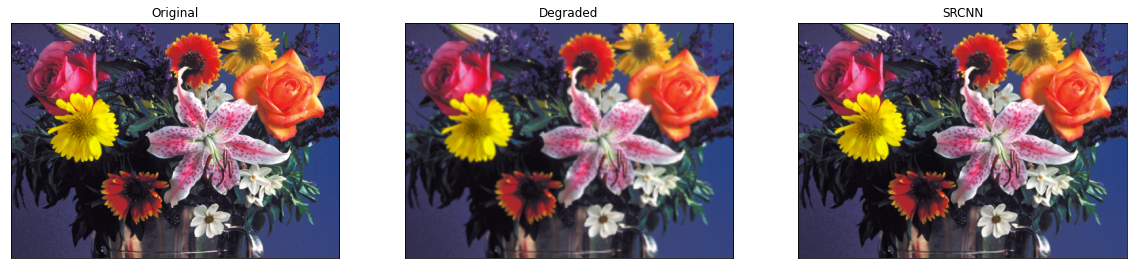

In [111]:
show_results(ref, degraded, output)

わ、わからん・・・

他の画像でもいくつか試してみる。